# Random_forest
* 모델1
* upsampling + MinMax_Scaler

In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import seaborn as sns
%matplotlib inline
import joblib

In [4]:
# 데이터 로딩
pdf = pd.read_csv('./MinMax_model01.csv', encoding='utf-8')
pdf

,일시,WIND_SPEED,GUST_WIND,SIG_WAVE,MAX_WAVE,HPA,특보강도
0,2012-08-02 04:00:00,0.334646,0.409742,0.107143,0.128205,0.463588,1.0
1,2018-06-15 18:00:00,0.350394,0.438395,0.107143,0.115385,0.529307,1.0
2,2018-04-24 12:00:00,0.188976,0.375358,0.089286,0.089744,0.467140,1.0
3,2018-03-22 06:00:00,0.094488,0.300860,0.285714,0.282051,0.536412,1.0
4,2018-03-17 08:00:00,0.192913,0.249284,0.107143,0.115385,0.870337,1.0
...,...,...,...,...,...,...,...
199504,2018-03-20 10:00:00,0.578740,0.756447,0.392857,0.410256,0.735346,2.0
199505,2012-04-03 07:00:00,0.212598,0.469914,0.196429,0.217949,0.197158,2.0
199506,2018-07-03 20:00:00,0.622047,0.767908,0.410714,0.435897,0.111901,2.0
199507,2018-03-20 09:00:00,0.531496,0.704871,0.357143,0.371795,0.721137,2.0


In [5]:
pdf = pdf.set_index('일시')
pdf

,WIND_SPEED,GUST_WIND,SIG_WAVE,MAX_WAVE,HPA,특보강도
일시,,,,,,
2012-08-02 04:00:00,0.334646,0.409742,0.107143,0.128205,0.463588,1.0
2018-06-15 18:00:00,0.350394,0.438395,0.107143,0.115385,0.529307,1.0
2018-04-24 12:00:00,0.188976,0.375358,0.089286,0.089744,0.467140,1.0
2018-03-22 06:00:00,0.094488,0.300860,0.285714,0.282051,0.536412,1.0
2018-03-17 08:00:00,0.192913,0.249284,0.107143,0.115385,0.870337,1.0
...,...,...,...,...,...,...
2018-03-20 10:00:00,0.578740,0.756447,0.392857,0.410256,0.735346,2.0
2012-04-03 07:00:00,0.212598,0.469914,0.196429,0.217949,0.197158,2.0
2018-07-03 20:00:00,0.622047,0.767908,0.410714,0.435897,0.111901,2.0


In [6]:
print(pdf["특보강도"].value_counts())

1.0    66503
0.0    66503
2.0    66503
Name: 특보강도, dtype: int64


In [7]:
# 데이터셋
X_data = pdf[['WIND_SPEED', 'GUST_WIND', 'SIG_WAVE', 'MAX_WAVE', 'HPA']]
y_target = pdf['특보강도']

In [8]:
# 훈련세트와 테스트 세트로 나누기
# pdf = train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

* 학습시작

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_target, random_state=42, test_size=0.2)

In [10]:
X_train.shape

(159607, 5)

In [11]:
X_test.shape

(39902, 5)

In [12]:
y_train.shape

(159607,)

In [13]:
y_test.shape

(39902,)

In [14]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199509 entries, 2012-08-02 04:00:00 to 2018-03-22 03:00:00
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   WIND_SPEED  199509 non-null  float64
 1   GUST_WIND   199509 non-null  float64
 2   SIG_WAVE    199509 non-null  float64
 3   MAX_WAVE    199509 non-null  float64
 4   HPA         199509 non-null  float64
 5   특보강도        199509 non-null  float64
dtypes: float64(6)
memory usage: 14.7+ MB


In [15]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_target.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_target).value_counts())

레이블 테스트 세트 크기 : (199509,)
테스트 세트 레이블 0 과 1의 분포도
1.0    66503
0.0    66503
2.0    66503
Name: 특보강도, dtype: int64


In [16]:
# 교차 검증 수행 (훈련세트와 검증세트 점수 비교해서 과대적합 파악)
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, X_data, y_target,
                        return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))


0.9999899753927218 0.990491690356016


In [17]:
# 랜덤 포레스트 특성 중요도 출력
# 결정트리랑 비교 해보기
rf.fit(X_data, y_target)
print(rf.feature_importances_)

[0.13202633 0.2378497  0.23154015 0.28044565 0.11813816]


In [18]:
# OOB 점수를 출력
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_data, y_target)
print(rf.oob_score_)

0.995940032780476


In [19]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9951


In [20]:
# RandomForest의 하이퍼 파라미터 default 상태
model = RandomForestClassifier()
model

RandomForestClassifier()

* plot

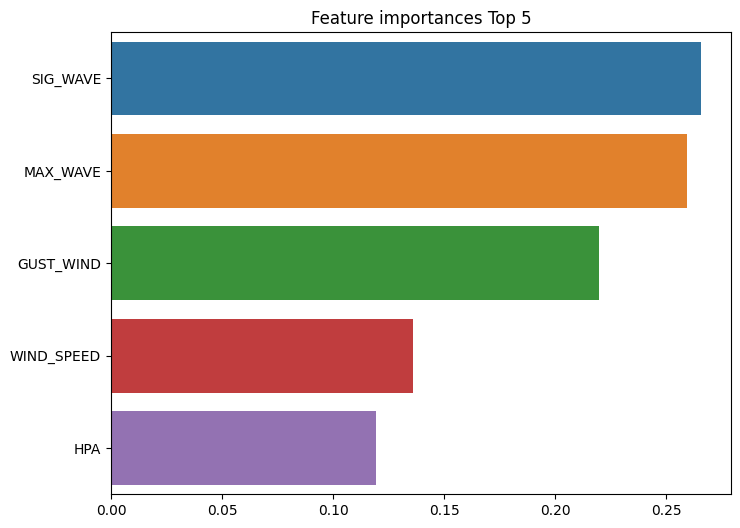

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 5')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

* 하이퍼 파라미터

In [22]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9557


In [23]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 12,
                                min_samples_leaf = 8,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9592


* 모델 저장

In [45]:
joblib.dump(rf_clf1, 'Random_forest_model_01.pkl')

['Random_forest_model_01.pkl']

* 평가지표

In [24]:
class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    
    # 입력값으로 들어오는 X 데이터 셋의 크기만큼 모두 0값으로 만들어서 반환
    # 분류의 대상이 되는 숫자가 7이든 아니든 상관없이 다수의 레이블 값인 0으로 만들어서 반환
    
    def predict(self,X):
        return np.zeros( (len(X), 1) , dtype=bool)

In [25]:
# 불균형한 레이블 데이터 분포도 확인. 
print('레이블 테스트 세트 크기 :', y_target.shape)
print('테스트 세트 레이블 0 과 1의 분포도')
print(pd.Series(y_target).value_counts())

레이블 테스트 세트 크기 : (199509,)
테스트 세트 레이블 0 과 1의 분포도
1.0    66503
0.0    66503
2.0    66503
Name: 특보강도, dtype: int64


In [26]:
# Fake Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()

fakeclf.fit(X_train , y_train)

fakepred = fakeclf.predict(X_test)

print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test , fakepred)))

모든 예측을 0으로 하여도 정확도는:0.333


# 평가지표

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [28]:
def print_metrics(y, pred_y, title=None) :
    print(title)
    print("정확도:", accuracy_score(y, pred_y))
    print('재현율(recall):', recall_score(y, pred_y, average='macro'))
    print('정밀도(precision):', precision_score(y, pred_y, average='macro'))
    print('F1 score:', f1_score(y, pred_y,average='macro'))

print_metrics(y_test, pred, '랜덤포레스트 결과')

랜덤포레스트 결과
정확도: 0.9591749786978097
재현율(recall): 0.9590752022873757
정밀도(precision): 0.9597800709613059
F1 score: 0.9589794175137305


In [30]:
def print_metrics(y_test, pred, title=None) :
    print(title)
    print("정확도:", accuracy_score(y_test, pred))
    print('재현율(recall):', recall_score(y_test, pred, average='weighted'))
    print('정밀도(precision):', precision_score(y_test, pred, average='weighted'))
    print('F1 score:', f1_score(y_test, pred,average='weighted'))
    print('오차행렬:', confusion_matrix(y_test, pred))

print_metrics(y_test, pred, '랜덤포레스트 결과')

랜덤포레스트 결과
정확도: 0.9591749786978097
재현율(recall): 0.9591749786978097
정밀도(precision): 0.9599956344628167
F1 score: 0.9591387603915924
오차행렬: [[12134  1161     2]
 [  444 12731    22]
 [    0     0 13408]]


* Dummy

In [72]:
from sklearn.dummy import DummyClassifier

In [73]:
dummy = DummyClassifier(strategy='stratified').fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy 점수: {:.2f}".format(dummy.score(X_test, y_test))) # dummy 점수: 0.34

dummy 점수: 0.34


In [74]:
logreg = RandomForestClassifier().fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg 점수: {:.2f}".format(logreg.score(X_test, y_test))) # logreg 점수: 0.99

logreg 점수: 0.99


In [31]:
# 랜덤 포레스트 평가지표
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     13297
         1.0       0.92      0.96      0.94     13197
         2.0       1.00      1.00      1.00     13408

    accuracy                           0.96     39902
   macro avg       0.96      0.96      0.96     39902
weighted avg       0.96      0.96      0.96     39902



In [32]:
# 오차행렬
cm = confusion_matrix(y_test, pred)

In [33]:
cm

array([[12134,  1161,     2],
       [  444, 12731,    22],
       [    0,     0, 13408]], dtype=int64)